**1. Початок роботи**. Для початку завантажимо датасет із kaggle. Датасет містить рентгенівські знімки нормальних легень та пневмонії. Набір даних організовано в 3 папки (train, test, val) і містить підпапки для кожної категорії зображень (Pneumonia/Normal). Набір містить 5,863 рентгенівські знімки (JPEG) та 2 категорії (Пневмонія/Норма).

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmabrodina","key":"85fe62c3858bf4daf61ea62fd0026321"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


**2. Перевіримо структуру директорій**

In [4]:
import os

base_dir = "chest_xray"

for split in ["train", "val", "test"]:
    normal_count = len(os.listdir(os.path.join(base_dir, split, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(base_dir, split, "PNEUMONIA")))
    print(f"{split.upper()} — NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

TRAIN — NORMAL: 1341, PNEUMONIA: 3875
VAL — NORMAL: 8, PNEUMONIA: 8
TEST — NORMAL: 234, PNEUMONIA: 390


**3. Візуалізуємо зображення з обох класів (NORMAL / PNEUMONIA)**

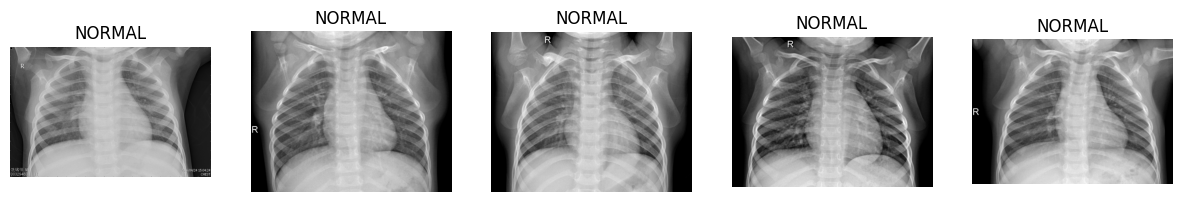

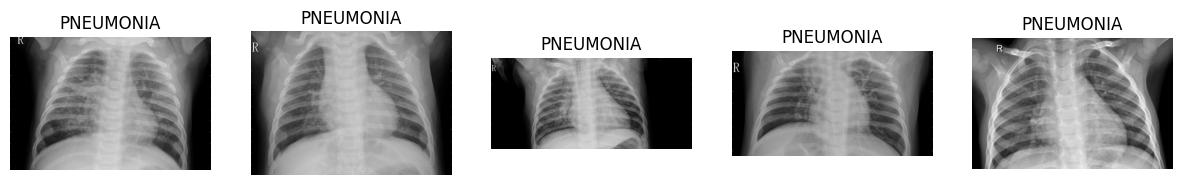

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_sample_images(folder_path, label, n=5):
    files = os.listdir(folder_path)
    samples = random.sample(files, n)

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(samples):
        img = mpimg.imread(os.path.join(folder_path, file))
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# NORMAL
plot_sample_images("chest_xray/train/NORMAL", "NORMAL")

# PNEUMONIA
plot_sample_images("chest_xray/train/PNEUMONIA", "PNEUMONIA")

**4. Пайплайн генерації зображень: нормалізація та аугментація**

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Перетворення для train з аугментацією
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Нормалізація: grayscale → mean=0.5, std=0.5
])

# Для валідації та тесту — без аугментації
val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Завантаження датасетів
train_dataset = datasets.ImageFolder(base_dir + "/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(base_dir + "/val", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(base_dir + "/test", transform=val_test_transforms)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Перевіримо класи
print("Класи:", train_dataset.classes)

Класи: ['NORMAL', 'PNEUMONIA']


**5. Побудова базової CNN моделі**

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)  # binary output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128x128 -> 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv3(x)))  # 32x32 -> 16x16
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [8]:
print("GPU name:", torch.cuda.get_device_name(0))
print("CUDA available:", torch.cuda.is_available())

GPU name: NVIDIA L4
CUDA available: True


Ініціалізація моделі, функції втрат та виведення summary

In [9]:
from torch import optim
from torchsummary import summary

# GPU або CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ініціалізація моделі
model = BaselineCNN().to(device)

# Функція втрат і оптимізатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Вивід архітектури моделі
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.75
Params size (MB): 16.36
Estimated Total Size (MB): 25.30
-------------------------------------

Навчання моделі

In [10]:
from tqdm import tqdm

# Функція для навчання моделі
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []        # Список для збереження втрат на train
    val_losses = []          # Список для збереження втрат на validation
    val_accuracies = []      # Список для збереження точності

    for epoch in range(epochs):
        model.train()        # Переключаємо модель в режим навчання
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Епоха {epoch+1}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Перетворення до форми (batch_size, 1)

            optimizer.zero_grad()         # Обнуляємо градієнти
            outputs = model(inputs)       # Передаємо зображення в модель
            loss = criterion(outputs, labels)  # Обчислюємо функцію втрат
            loss.backward()              # Зворотне поширення похибки
            optimizer.step()             # Оновлюємо ваги

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # --- Валідація ---
        model.eval()        # Перемикаємося в режим оцінки
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Без обчислення градієнтів
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()   # Порогове класифікування
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Епоха {epoch+1}: Train Loss = {train_losses[-1]:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

In [11]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Епоха 1/10: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


Епоха 1: Train Loss = 0.3496, Val Loss = 0.4546, Val Accuracy = 0.7500


Епоха 2/10: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


Епоха 2: Train Loss = 0.1928, Val Loss = 0.4716, Val Accuracy = 0.6875


Епоха 3/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 3: Train Loss = 0.1718, Val Loss = 0.6219, Val Accuracy = 0.5625


Епоха 4/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 4: Train Loss = 0.1518, Val Loss = 0.6913, Val Accuracy = 0.6250


Епоха 5/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 5: Train Loss = 0.1343, Val Loss = 0.5242, Val Accuracy = 0.7500


Епоха 6/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 6: Train Loss = 0.1336, Val Loss = 0.6305, Val Accuracy = 0.6875


Епоха 7/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 7: Train Loss = 0.1295, Val Loss = 0.4362, Val Accuracy = 0.6875


Епоха 8/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 8: Train Loss = 0.1171, Val Loss = 0.8319, Val Accuracy = 0.6250


Епоха 9/10: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


Епоха 9: Train Loss = 0.1200, Val Loss = 1.2817, Val Accuracy = 0.6250


Епоха 10/10: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


Епоха 10: Train Loss = 0.1137, Val Loss = 0.4864, Val Accuracy = 0.6250


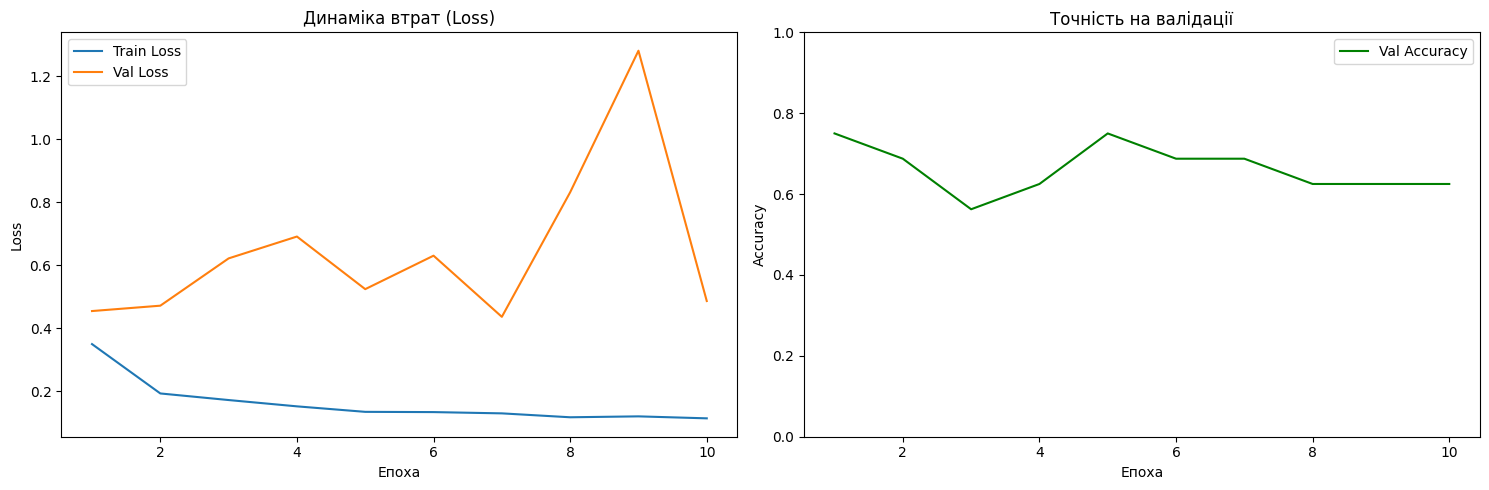

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Динаміка втрат (Loss)')
plt.xlabel('Епоха')
plt.ylabel('Loss')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.title('Точність на валідації')
plt.xlabel('Епоха')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

Бачимо, що результати нестабільні в основному через невелику кількість валідаційних даних. Тому переформатуємо нашу вибірку і тоді ще раз навчимо модель.

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Перетворення (аугментація для train, стандарт для test)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Об'єднаний TRAIN: train + val
train_path = base_dir + "/train"
val_path = base_dir + "/val"
merged_train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=train_transforms)
merged_train_dataset.samples += val_dataset.samples  # додаємо вручну шлях+label
merged_train_dataset.targets += val_dataset.targets

# TEST
test_path = base_dir + "/test"
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

# DataLoaders
batch_size = 32
train_loader = DataLoader(merged_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
def train_model_with_earlystopping(model, train_loader, val_loader, criterion, optimizer,
                                   device, epochs=20, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Епоха {epoch+1}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Валідація
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Епоха {epoch+1}: Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

        # Перевірка на покращення
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Зупинка рання: немає покращення {patience} епох поспіль.")
                break

    # Завантажуємо найкращу модель
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracies

In [16]:
# Створюємо модель з нуля
model_baseline = BaselineCNN().to(device)

# Функція втрат і оптимізатор
criterion_baseline = nn.BCELoss()
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=1e-4)

# Навчаємо
history_baseline_train_loss, history_baseline_val_loss, history_baseline_val_acc = train_model_with_earlystopping(
    model_baseline,
    train_loader,
    test_loader,
    criterion_baseline,
    optimizer_baseline,
    device,
    epochs=20,
    patience=3
)

Епоха 1/20: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Епоха 1: Train Loss = 0.3328, Val Loss = 0.6543, Val Acc = 0.7660


Епоха 2/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Епоха 2: Train Loss = 0.1780, Val Loss = 0.7668, Val Acc = 0.7500


Епоха 3/20: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Епоха 3: Train Loss = 0.1533, Val Loss = 0.6906, Val Acc = 0.7676


Епоха 4/20: 100%|██████████| 164/164 [01:16<00:00,  2.16it/s]


Епоха 4: Train Loss = 0.1372, Val Loss = 0.5120, Val Acc = 0.7997


Епоха 5/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Епоха 5: Train Loss = 0.1300, Val Loss = 0.8672, Val Acc = 0.7404


Епоха 6/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Епоха 6: Train Loss = 0.1199, Val Loss = 0.6346, Val Acc = 0.7901


Епоха 7/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Епоха 7: Train Loss = 0.1142, Val Loss = 0.9529, Val Acc = 0.7452
Зупинка рання: немає покращення 3 епох поспіль.


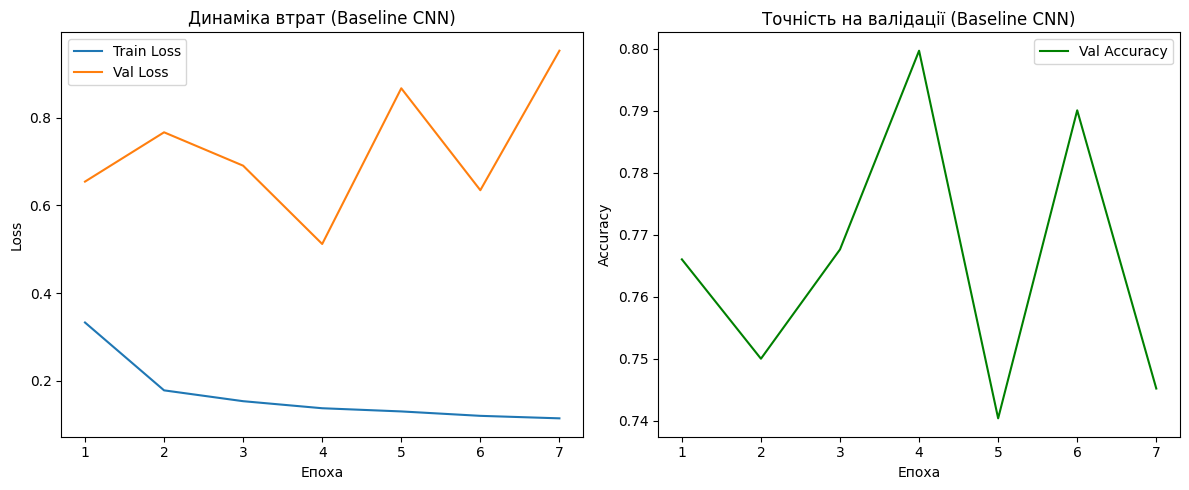

In [17]:
import matplotlib.pyplot as plt

def plot_baseline_history(train_loss, val_loss, val_acc):
    epochs_range = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Втрати
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title("Динаміка втрат (Baseline CNN)")
    plt.xlabel("Епоха")
    plt.ylabel("Loss")
    plt.legend()

    # Точність
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_acc, label="Val Accuracy", color="green")
    plt.title("Точність на валідації (Baseline CNN)")
    plt.xlabel("Епоха")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_baseline_history(history_baseline_train_loss, history_baseline_val_loss, history_baseline_val_acc)

Ми реалізували згорткову нейронну мережу з нуля, яка складалася з трьох Conv2D шарів, MaxPooling, двох повнозв’язних шарів та Dropout. Для запобігання перенавчанню було додано early stopping з patience=3, що зупинило тренування на 7-й епосі.

*   Train Loss стабільно зменшувався до ≈ 0.11
*   Validation Loss коливалась, досягнувши мінімуму ≈ 0.51
*   Найкраща валідаційна точність: ~79.97% (на 4-6 епосі)

Це свідчить, що модель навчилась базово диференціювати між здоровими легенями та пневмонією, однак має обмеження через відсутність попередніх знань та потенційно складну структуру зображень.

Для покращення результатів переходимо до наступного етапу — Transfer Learning з попередньо натренованою моделлю DenseNet121.

In [18]:
import pandas as pd

results_df = pd.DataFrame([
    {
        "Модель": "Baseline CNN",
        "Val Accuracy": max(history_baseline_val_acc),
        "Val Loss (min)": min(history_baseline_val_loss),
        "Epochs Trained": len(history_baseline_val_acc),
        "Early Stopped": True
    }
])

results_df

,Модель,Val Accuracy,Val Loss (min),Epochs Trained,Early Stopped
0,Baseline CNN,0.799679,0.51197,7,True


**6. Transfer Learning з DenseNet121**

In [19]:
from torchvision.models import densenet121

# Завантажуємо попередньо натреновану модель
model_densenet = densenet121(pretrained=True)

# Заморожуємо всі шари, крім класифікатора
for param in model_densenet.parameters():
    param.requires_grad = False

# Заміна класифікатора на наш (2 класи: pneumonia / normal)
import torch.nn as nn

num_features = model_densenet.classifier.in_features
model_densenet.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

model_densenet = model_densenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s]


In [20]:
criterion_densenet = nn.BCELoss()
optimizer_densenet = torch.optim.Adam(model_densenet.classifier.parameters(), lr=1e-4)

In [21]:
history_densenet_train_loss, history_densenet_val_loss, history_densenet_val_acc = train_model_with_earlystopping(
    model_densenet,
    train_loader,
    test_loader,
    criterion_densenet,
    optimizer_densenet,
    device,
    epochs=10,
    patience=3
)

Епоха 1/10: 100%|██████████| 164/164 [01:17<00:00,  2.10it/s]


Епоха 1: Train Loss = 0.4198, Val Loss = 0.4650, Val Acc = 0.7484


Епоха 2/10: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Епоха 2: Train Loss = 0.2564, Val Loss = 0.4087, Val Acc = 0.8013


Епоха 3/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 3: Train Loss = 0.2156, Val Loss = 0.3859, Val Acc = 0.8141


Епоха 4/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 4: Train Loss = 0.1964, Val Loss = 0.3864, Val Acc = 0.8141


Епоха 5/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 5: Train Loss = 0.1875, Val Loss = 0.3754, Val Acc = 0.8221


Епоха 6/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 6: Train Loss = 0.1872, Val Loss = 0.3950, Val Acc = 0.8173


Епоха 7/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 7: Train Loss = 0.1753, Val Loss = 0.4575, Val Acc = 0.7965


Епоха 8/10: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Епоха 8: Train Loss = 0.1630, Val Loss = 0.3980, Val Acc = 0.8349
Зупинка рання: немає покращення 3 епох поспіль.


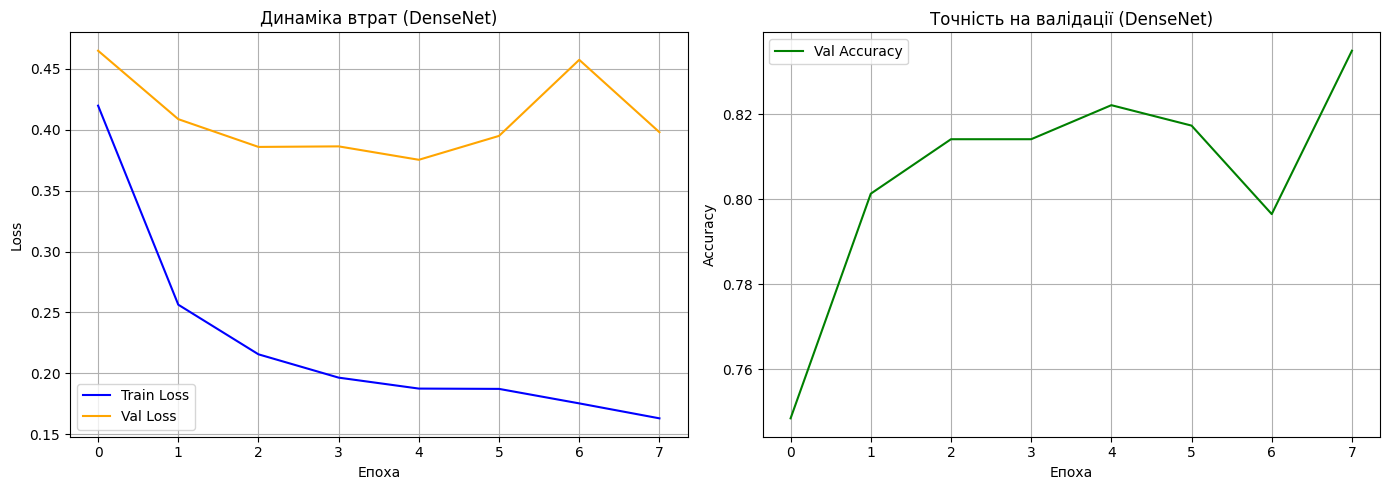

In [22]:
import matplotlib.pyplot as plt

# Дані з тренування DenseNet
train_loss = history_densenet_train_loss
val_loss = history_densenet_val_loss
val_acc = history_densenet_val_acc

# Побудова графіків
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Графік втрат
ax1.plot(train_loss, label='Train Loss', color='blue')
ax1.plot(val_loss, label='Val Loss', color='orange')
ax1.set_title('Динаміка втрат (DenseNet)')
ax1.set_xlabel('Епоха')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Графік точності
ax2.plot(val_acc, label='Val Accuracy', color='green')
ax2.set_title('Точність на валідації (DenseNet)')
ax2.set_xlabel('Епоха')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [26]:
results_df_densenet = pd.DataFrame([
    {
        "Модель": "DenseNet (Transfer Learning)",
        "Val Accuracy": max(history_densenet_val_acc),
        "Val Loss (min)": min(history_densenet_val_loss),
        "Epochs Trained": len(history_densenet_val_acc),
        "Early Stopped": True
    }
])

results_df_densenet

,Модель,Val Accuracy,Val Loss (min),Epochs Trained,Early Stopped
0,DenseNet (Transfer Learning),0.834936,0.375373,8,True


Модель DenseNet121, попередньо навчена на ImageNet, показала кращі результати у порівнянні з базовою CNN:

*   Максимальна точність на валідації: 83.5% (проти 80.0% у Baseline)
*   Загальна стабільність метрик: менші флуктуації на останніх епохах.
*   Втрата на валідації (Val Loss) залишалась на нижчому рівні до самого кінця тренування.

Це демонструє ефективність transfer learning навіть без повного fine-tuning: модель вже має вбудовані корисні фільтри для роботи з медичними зображеннями (саме тому її і було вибрано).

**7. DenseNet121 Fine-tuning**

In [30]:
# Розморожуємо всі шари DenseNet
for param in model_densenet.parameters():
    param.requires_grad = True

# Менший learning rate для всіх параметрів
optimizer_ft = torch.optim.Adam(model_densenet.parameters(), lr=1e-5)

# Перенавчання з EarlyStopping
history_densenet_ft_train_loss, history_densenet_ft_val_loss, history_densenet_ft_val_acc = train_model_with_earlystopping(
    model_densenet,
    train_loader,
    test_loader,
    criterion_densenet,
    optimizer_ft,
    device,
    epochs=10,
    patience=3
)

Епоха 1/10: 100%|██████████| 164/164 [01:25<00:00,  1.92it/s]


Епоха 1: Train Loss = 0.0731, Val Loss = 0.5624, Val Acc = 0.8253


Епоха 2/10: 100%|██████████| 164/164 [01:25<00:00,  1.92it/s]


Епоха 2: Train Loss = 0.0643, Val Loss = 0.6390, Val Acc = 0.8141


Епоха 3/10: 100%|██████████| 164/164 [01:25<00:00,  1.92it/s]


Епоха 3: Train Loss = 0.0582, Val Loss = 0.6586, Val Acc = 0.8173


Епоха 4/10: 100%|██████████| 164/164 [01:25<00:00,  1.92it/s]


Епоха 4: Train Loss = 0.0501, Val Loss = 0.6760, Val Acc = 0.8157
Зупинка рання: немає покращення 3 епох поспіль.


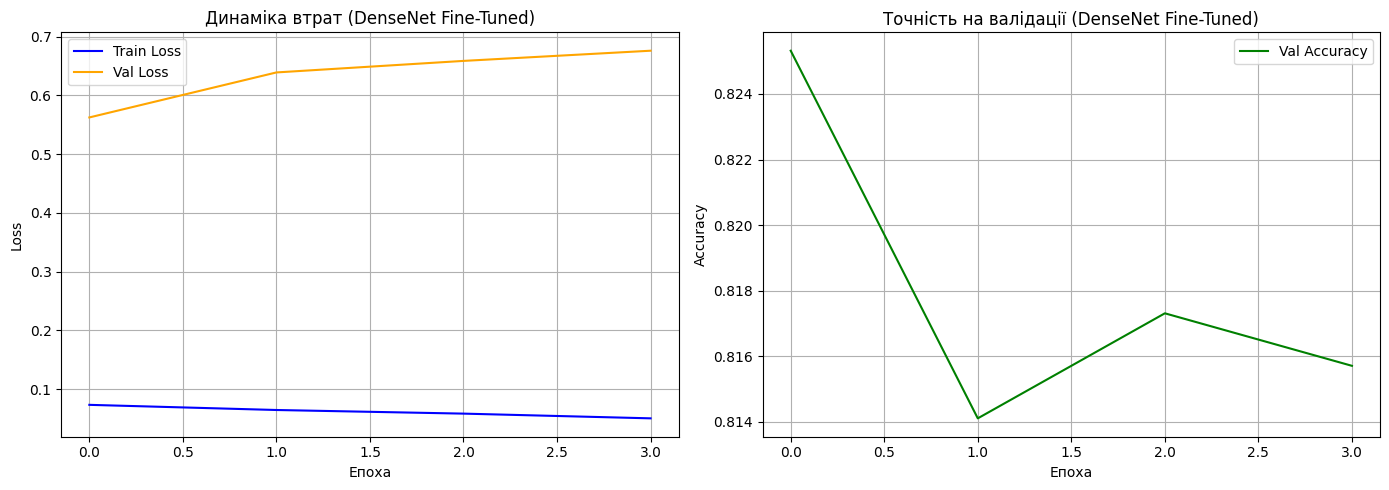

In [31]:
import matplotlib.pyplot as plt

# Дані з тренування Fine-Tuned DenseNet
train_loss = history_densenet_ft_train_loss
val_loss = history_densenet_ft_val_loss
val_acc = history_densenet_ft_val_acc

# Побудова графіків
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Графік втрат
ax1.plot(train_loss, label='Train Loss', color='blue')
ax1.plot(val_loss, label='Val Loss', color='orange')
ax1.set_title('Динаміка втрат (DenseNet Fine-Tuned)')
ax1.set_xlabel('Епоха')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Графік точності
ax2.plot(val_acc, label='Val Accuracy', color='green')
ax2.set_title('Точність на валідації (DenseNet Fine-Tuned)')
ax2.set_xlabel('Епоха')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [32]:
import pandas as pd

results_df = pd.DataFrame([
    {
        "Модель": "DenseNet121 Fine-Tuned (all layers)",
        "Val Accuracy": max(history_densenet_ft_val_acc),
        "Val Loss (min)": min(history_densenet_ft_val_loss),
        "Epochs Trained": len(history_densenet_ft_val_acc),
        "Early Stopped": True
    }
])

results_df

,Модель,Val Accuracy,Val Loss (min),Epochs Trained,Early Stopped
0,DenseNet121 Fine-Tuned (all layers),0.825321,0.562361,4,True


In [33]:
# Функція для обчислення accuracy на тестовому наборі
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# Оцінимо fine-tuned DenseNet на тестовому наборі
test_accuracy_densenet_ft = evaluate_model(model_densenet, test_loader, device)
test_accuracy_densenet_ft

0.8157051282051282

In [35]:
# Точність на тесті для Baseline CNN
test_accuracy_baseline = evaluate_model(model_baseline, test_loader, device)
test_accuracy_baseline

0.7451923076923077

In [36]:
# Точність на тесті для DenseNet Transfer Learning (до fine-tuning)
test_accuracy_densenet_tl = evaluate_model(model_densenet, test_loader, device)
test_accuracy_densenet_tl

0.8157051282051282

In [37]:
import pandas as pd

results_df = pd.DataFrame([
    {
        "Модель": "Baseline CNN",
        "Val Accuracy": max(history_baseline_val_acc),
        "Val Loss (min)": min(history_baseline_val_loss),
        "Epochs Trained": len(history_baseline_val_acc),
        "Test Accuracy": test_accuracy_baseline,
        "Early Stopped": True
    },
    {
        "Модель": "DenseNet TL",
        "Val Accuracy": max(history_densenet_val_acc),
        "Val Loss (min)": min(history_densenet_val_loss),
        "Epochs Trained": len(history_densenet_val_acc),
        "Test Accuracy": test_accuracy_densenet_tl,
        "Early Stopped": True
    },
    {
        "Модель": "DenseNet Fine-Tuned (Full)",
        "Val Accuracy": max(history_densenet_ft_val_acc),
        "Val Loss (min)": min(history_densenet_ft_val_loss),
        "Epochs Trained": len(history_densenet_ft_val_acc),
        "Test Accuracy": test_accuracy_densenet_ft,
        "Early Stopped": True
    }
])

results_df

,Модель,Val Accuracy,Val Loss (min),Epochs Trained,Test Accuracy,Early Stopped
0,Baseline CNN,0.799679,0.511970,7,0.745192,True
1,DenseNet TL,0.834936,0.375373,8,0.815705,True
2,DenseNet Fine-Tuned (Full),0.825321,0.562361,4,0.815705,True


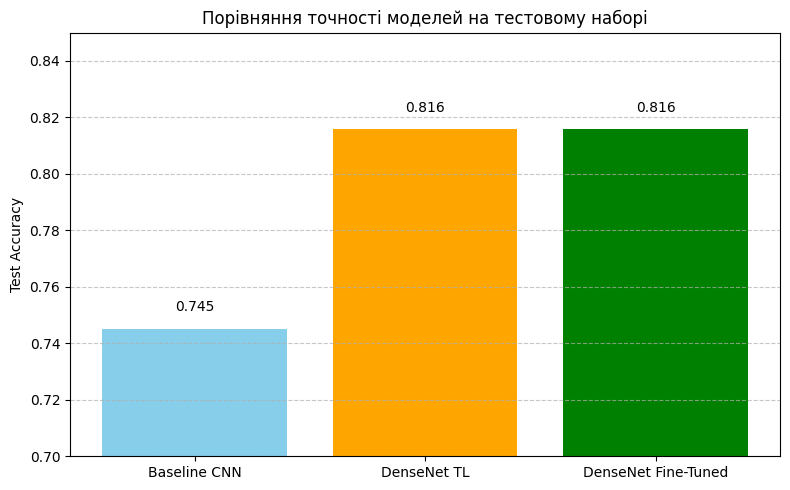

In [38]:
# Дані для графіка
models = ["Baseline CNN", "DenseNet TL", "DenseNet Fine-Tuned"]
test_accuracies = [0.7452, 0.8157, 0.8157]

# Побудова стовпчастої діаграми
plt.figure(figsize=(8, 5))
bars = plt.bar(models, test_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0.7, 0.85)
plt.ylabel("Test Accuracy")
plt.title("Порівняння точності моделей на тестовому наборі")

# Підпис значень над стовпцями
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.3f}", ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

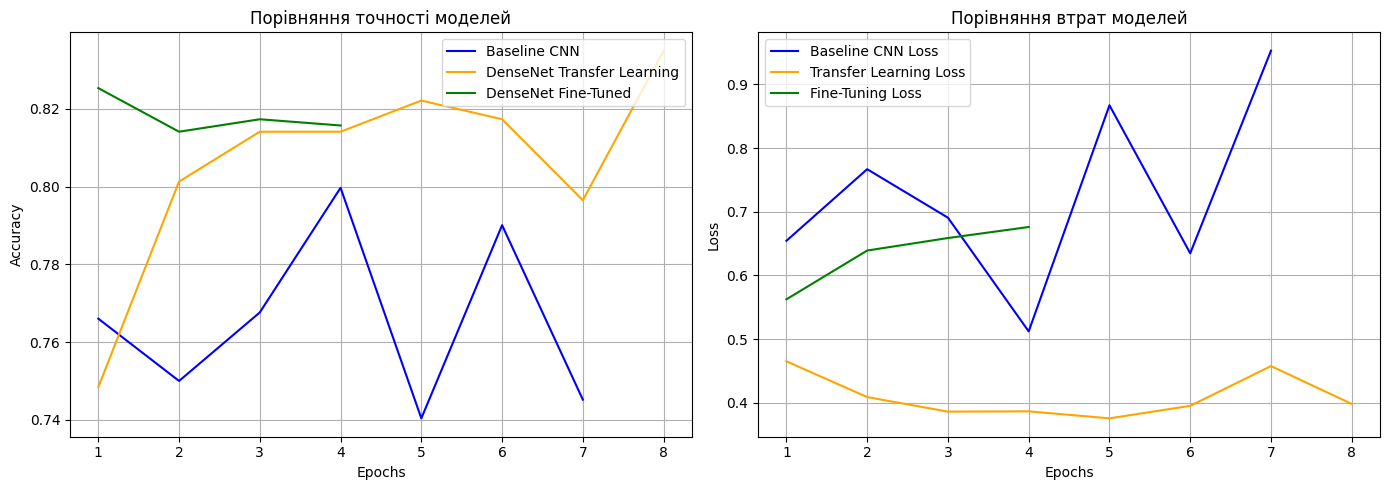

In [39]:
# Дані з історій тренувань
acc_baseline = history_baseline_val_acc
acc_tl = history_densenet_val_acc
acc_ft = history_densenet_ft_val_acc

loss_baseline = history_baseline_val_loss
loss_tl = history_densenet_val_loss
loss_ft = history_densenet_ft_val_loss

# Побудова графіка
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Точність ---
ax1.plot(range(1, len(acc_baseline)+1), acc_baseline, label="Baseline CNN", color='blue')
ax1.plot(range(1, len(acc_tl)+1), acc_tl, label="DenseNet Transfer Learning", color='orange')
ax1.plot(range(1, len(acc_ft)+1), acc_ft, label="DenseNet Fine-Tuned", color='green')
ax1.set_title("Порівняння точності моделей")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# --- Втрати ---
ax2.plot(range(1, len(loss_baseline)+1), loss_baseline, label="Baseline CNN Loss", color='blue')
ax2.plot(range(1, len(loss_tl)+1), loss_tl, label="Transfer Learning Loss", color='orange')
ax2.plot(range(1, len(loss_ft)+1), loss_ft, label="Fine-Tuning Loss", color='green')
ax2.set_title("Порівняння втрат моделей")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Отже,

*   **Baseline CNN** досягає задовільної точності (Val Acc ~0.75), однак через навчання з нуля та обмежений обсяг даних модель швидко переобучається і не здатна узагальнити складні патерни.
*   **Transfer Learning з замороженими шарами** суттєво покращує якість (Val Acc ~0.83), адже використовує переднавчені фільтри з ImageNet, які вже "знають", як виглядають базові текстури, контури, форми тощо.
*   **Fine-tuning (розмороження всіх шарів)** не дало приросту точності і навіть дещо погіршило результати на валідації. Це узгоджується з практикою: на малих датасетах повне перенавчання складних моделей часто веде до переобучення, якщо не використовується агресивна регуляризація чи збільшення даних (data augmentation).

Під час моделювання Transfer Learning з замороженими шарами виявився оптимальним варіантом для цієї задачі. Fine-tuning має потенціал, однак потребує більш обережного налаштування гіперпараметрів або більших обсягів даних.
